In [1]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import sys
import os

sys.path.append(os.path.abspath('..'))
project_root = os.path.dirname(os.path.dirname(os.path.abspath('.')))
if project_root not in sys.path:
    sys.path.append(project_root)

from train.meta_reasoner import config as meta_config
from train.meta_reasoner.feature_generator import generate_meta_features
from src.logger import logger
from src import config as main_config

e:\agentic-reasoning-engine\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
try:
    # Load the artifact
    model_path = os.path.join(meta_config.MODEL_OUTPUT_DIR, meta_config.MODEL_NAME)
    artifact = joblib.load(model_path)
    logger.info(f"Loaded meta-reasoner artifact from {model_path}")

    # Extract components
    meta_reasoner = artifact['meta_reasoner']
    label_encoder = artifact['label_encoder']

    # Generate the dataset for evaluation
    features, labels = generate_meta_features()
    if features is None:
        raise FileNotFoundError("Could not generate meta-features.")
    
    # Load the sentence transformer for inference
    embedding_model = SentenceTransformer(main_config.EMBEDDING_MODEL_NAME)
    logger.info(f"Sentence transformer '{main_config.EMBEDDING_MODEL_NAME}' is ready.")
    
except FileNotFoundError as e:
    logger.error(f"Error: {e}. Please run the full training pipeline first.")

2025-10-07 23:15:51,924 - AgenticReasoningPipeline - INFO - Loaded meta-reasoner artifact from e:\agentic-reasoning-engine\models\meta_reasoner.pkl (2154360255.py:5)
2025-10-07 23:15:51,925 - AgenticReasoningPipeline - INFO - Generating features and heuristic labels for meta-reasoner... (feature_generator.py:21)
2025-10-07 23:15:51,940 - AgenticReasoningPipeline - INFO - Meta-feature generation complete. Found 4 potential ANALOGY strategies. (feature_generator.py:49)
2025-10-07 23:15:55,716 - AgenticReasoningPipeline - INFO - Sentence transformer 'all-MiniLM-L6-v2' is ready. (2154360255.py:18)


In [3]:
# The model was trained on the full dataset, so we evaluate on the same data
# to see how well it learned the heuristic patterns.
y_true = label_encoder.transform(labels)
y_pred = meta_reasoner.predict(features)

print("--- Classification Report (Full Training Set) ---")
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print(report)

--- Classification Report (Full Training Set) ---
              precision    recall  f1-score   support

     ANALOGY       1.00      1.00      1.00         4
         LLM       1.00      1.00      1.00       380

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



--- Confusion Matrix (Full Training Set) ---


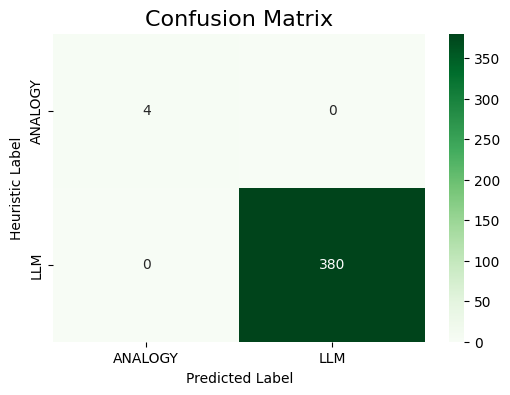

In [4]:
print("--- Confusion Matrix (Full Training Set) ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Heuristic Label')
plt.xlabel('Predicted Label')
plt.show()

In [5]:
def get_strategy(text: str):
    """Takes raw text and returns the predicted strategy from the meta-reasoner."""
    # Create embedding
    embedding = embedding_model.encode([text])
    
    # Get prediction from the meta-reasoner
    predicted_idx = meta_reasoner.predict(embedding)
    
    # Decode the index to its strategy name
    predicted_strategy = label_encoder.inverse_transform(predicted_idx)
    return predicted_strategy[0]

print("--- Running Inference Test ---")

# Test Case 1: A problem very similar to one in our dataset
problem1 = "Laura wants to travel between three locations, A, B, and C, starting and ending at A. What is the most efficient path?"
strategy1 = get_strategy(problem1)
print(f"Problem: '{problem1[:50]}...'\n -> Predicted Strategy: {strategy1}\n")

# Test Case 2: A more creative, open-ended problem
problem2 = "Write a short story about a robot who discovers music."
strategy2 = get_strategy(problem2)
print(f"Problem: '{problem2[:50]}...'\n -> Predicted Strategy: {strategy2}\n")

# Test Case 3: A classic riddle which may not have a close analogy
problem3 = "What has an eye, but cannot see?"
strategy3 = get_strategy(problem3)
print(f"Problem: '{problem3[:50]}...'\n -> Predicted Strategy: {strategy3}")

--- Running Inference Test ---
Problem: 'Laura wants to travel between three locations, A, ...'
 -> Predicted Strategy: LLM

Problem: 'Write a short story about a robot who discovers mu...'
 -> Predicted Strategy: LLM

Problem: 'What has an eye, but cannot see?...'
 -> Predicted Strategy: LLM


In [6]:
def get_strategy_with_confidence(text: str):
    """Returns strategy prediction with confidence scores for both options."""
    # Create embedding
    embedding = embedding_model.encode([text])
    
    # Get prediction probabilities
    probabilities = meta_reasoner.predict_proba(embedding)[0]
    
    # Get predicted class
    predicted_idx = meta_reasoner.predict(embedding)[0]
    predicted_strategy = label_encoder.inverse_transform([predicted_idx])[0]
    
    # Create confidence dictionary
    confidence_scores = {}
    for i, strategy in enumerate(label_encoder.classes_):
        confidence_scores[strategy] = probabilities[i]
    
    return predicted_strategy, confidence_scores

print("--- Enhanced Inference with Confidence Scores ---")
test_problems = [
    "Find the shortest route visiting Paris, London, and Berlin starting from Paris.",
    "Compose a poem about artificial intelligence and human emotions.",
    "If you have a 3-gallon jug and a 5-gallon jug, how do you measure exactly 4 gallons?",
    "Design a sustainable city for 100,000 people.",
    "A farmer needs to cross a river with a fox, chicken, and bag of corn."
]

for i, problem in enumerate(test_problems, 1):
    strategy, confidences = get_strategy_with_confidence(problem)
    print(f"\n{i}. Problem: '{problem[:60]}...'")
    print(f"   → Strategy: {strategy}")
    for strat, conf in confidences.items():
        print(f"      {strat}: {conf:.3f}")

--- Enhanced Inference with Confidence Scores ---

1. Problem: 'Find the shortest route visiting Paris, London, and Berlin s...'
   → Strategy: LLM
      ANALOGY: 0.000
      LLM: 1.000

2. Problem: 'Compose a poem about artificial intelligence and human emoti...'
   → Strategy: LLM
      ANALOGY: 0.040
      LLM: 0.960

3. Problem: 'If you have a 3-gallon jug and a 5-gallon jug, how do you me...'
   → Strategy: LLM
      ANALOGY: 0.010
      LLM: 0.990

4. Problem: 'Design a sustainable city for 100,000 people....'
   → Strategy: LLM
      ANALOGY: 0.020
      LLM: 0.980

5. Problem: 'A farmer needs to cross a river with a fox, chicken, and bag...'
   → Strategy: LLM
      ANALOGY: 0.020
      LLM: 0.980


--- Feature Importance Analysis ---


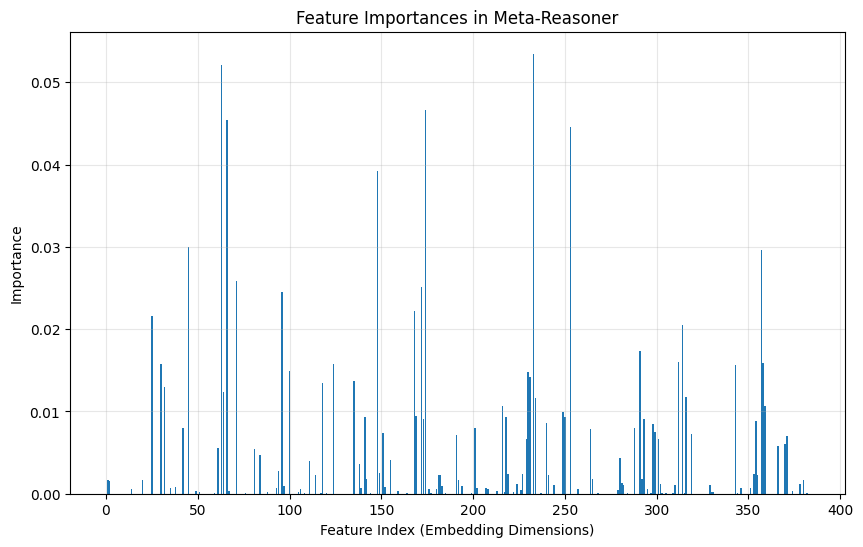

Top 10 most important features:
  1. Feature 233: 0.0535
  2. Feature 63: 0.0521
  3. Feature 174: 0.0466
  4. Feature 66: 0.0455
  5. Feature 253: 0.0446
  6. Feature 148: 0.0392
  7. Feature 45: 0.0299
  8. Feature 357: 0.0296
  9. Feature 71: 0.0259
  10. Feature 172: 0.0251


In [7]:
def analyze_feature_importance():
    """Analyze which features are most important for the meta-reasoner's decisions."""
    if hasattr(meta_reasoner, 'feature_importances_'):
        print("--- Feature Importance Analysis ---")
        
        # Since we're using embeddings, we can't name individual features
        # But we can see the distribution of importance
        importances = meta_reasoner.feature_importances_
        
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(importances)), importances)
        plt.title('Feature Importances in Meta-Reasoner')
        plt.xlabel('Feature Index (Embedding Dimensions)')
        plt.ylabel('Importance')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        print(f"Top 10 most important features:")
        top_indices = np.argsort(importances)[-10:][::-1]
        for i, idx in enumerate(top_indices):
            print(f"  {i+1}. Feature {idx}: {importances[idx]:.4f}")
        
        return importances
    else:
        print("Feature importances not available for this model type.")
        return None

# Analyze feature importance
feature_importances = analyze_feature_importance()

--- Strategy Distribution Analysis ---
Actual distribution in training data:
  ANALOGY: 4 samples (1.0%)
  LLM: 380 samples (99.0%)

Predicted distribution (should match closely):
  ANALOGY: 4 samples (1.0%)
  LLM: 380 samples (99.0%)


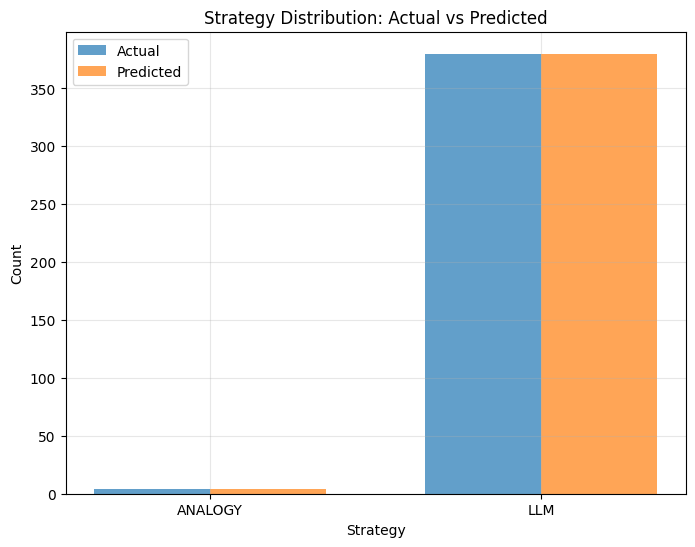

In [8]:
def analyze_strategy_distribution():
    """Analyze the distribution of strategies in the training data and predictions."""
    print("--- Strategy Distribution Analysis ---")
    
    # Actual distribution in training data
    unique, counts = np.unique(labels, return_counts=True)
    actual_dist = dict(zip(unique, counts))
    
    # Predicted distribution
    predicted_labels = label_encoder.inverse_transform(y_pred)
    unique_pred, counts_pred = np.unique(predicted_labels, return_counts=True)
    predicted_dist = dict(zip(unique_pred, counts_pred))
    
    print("Actual distribution in training data:")
    for strategy, count in actual_dist.items():
        percentage = (count / len(labels)) * 100
        print(f"  {strategy}: {count} samples ({percentage:.1f}%)")
    
    print("\nPredicted distribution (should match closely):")
    for strategy in label_encoder.classes_:
        count = predicted_dist.get(strategy, 0)
        percentage = (count / len(y_pred)) * 100
        print(f"  {strategy}: {count} samples ({percentage:.1f}%)")
    
    # Plot distribution comparison
    strategies = label_encoder.classes_
    actual_counts = [actual_dist.get(s, 0) for s in strategies]
    predicted_counts = [predicted_dist.get(s, 0) for s in strategies]
    
    x = np.arange(len(strategies))
    width = 0.35
    
    plt.figure(figsize=(8, 6))
    plt.bar(x - width/2, actual_counts, width, label='Actual', alpha=0.7)
    plt.bar(x + width/2, predicted_counts, width, label='Predicted', alpha=0.7)
    plt.xlabel('Strategy')
    plt.ylabel('Count')
    plt.title('Strategy Distribution: Actual vs Predicted')
    plt.xticks(x, strategies)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Analyze strategy distribution
analyze_strategy_distribution()

In [9]:
def evaluate_cross_validation():
    """Evaluate model performance using train-test split to check for overfitting."""
    from sklearn.metrics import accuracy_score
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    # Encode labels
    y_train_encoded = label_encoder.transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Train a new model for comparison (optional)
    # For now, we'll use the existing model and see how it performs on test data
    
    # Predict on test set
    y_test_pred = meta_reasoner.predict(X_test)
    
    # Calculate accuracy
    train_accuracy = accuracy_score(y_true, y_pred)
    test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
    
    print("--- Cross-Validation Style Evaluation ---")
    print(f"Training Accuracy (full dataset): {train_accuracy:.4f}")
    print(f"Test Accuracy (holdout set): {test_accuracy:.4f}")
    
    if train_accuracy - test_accuracy > 0.1:
        print("⚠️  Potential overfitting detected")
    else:
        print("✅ Model generalizes well")
    
    # Test set classification report
    print("\n--- Test Set Classification Report ---")
    test_report = classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_)
    print(test_report)
    
    return test_accuracy

# Evaluate cross-validation performance
test_accuracy = evaluate_cross_validation()

--- Cross-Validation Style Evaluation ---
Training Accuracy (full dataset): 1.0000
Test Accuracy (holdout set): 1.0000
✅ Model generalizes well

--- Test Set Classification Report ---
              precision    recall  f1-score   support

     ANALOGY       1.00      1.00      1.00         1
         LLM       1.00      1.00      1.00        76

    accuracy                           1.00        77
   macro avg       1.00      1.00      1.00        77
weighted avg       1.00      1.00      1.00        77



In [10]:
def analyze_decision_boundaries():
    """Analyze how the meta-reasoner makes strategic decisions."""
    print("--- Strategic Decision Boundary Analysis ---")
    
    # Get some example problems and their embeddings
    example_problems = [
        "Traveling salesman visiting 5 cities with known distances",
        "Write creative fiction about time travel paradox",
        "Logic puzzle with truth-tellers and liars on an island", 
        "Compose original music in the style of Beethoven",
        "Water jug measurement problem with 7L and 11L containers"
    ]
    
    print("Strategic analysis of example problems:")
    print("=" * 70)
    
    for problem in example_problems:
        strategy, confidences = get_strategy_with_confidence(problem)
        analogy_conf = confidences.get('ANALOGY', 0)
        llm_conf = confidences.get('LLM', 0)
        
        print(f"\nProblem: '{problem}'")
        print(f"Decision: {strategy}")
        print(f"Confidence: ANALOGY={analogy_conf:.3f}, LLM={llm_conf:.3f}")
        
        if analogy_conf > 0.7:
            reasoning = "High confidence in analogy - problem likely has close matches"
        elif llm_conf > 0.7:
            reasoning = "High confidence in LLM - problem likely requires creativity"
        else:
            reasoning = "Uncertain - problem may be borderline case"
        
        print(f"Reasoning: {reasoning}")

# Analyze decision boundaries
analyze_decision_boundaries()

--- Strategic Decision Boundary Analysis ---
Strategic analysis of example problems:

Problem: 'Traveling salesman visiting 5 cities with known distances'
Decision: LLM
Confidence: ANALOGY=0.000, LLM=1.000
Reasoning: High confidence in LLM - problem likely requires creativity

Problem: 'Write creative fiction about time travel paradox'
Decision: LLM
Confidence: ANALOGY=0.000, LLM=1.000
Reasoning: High confidence in LLM - problem likely requires creativity

Problem: 'Logic puzzle with truth-tellers and liars on an island'
Decision: LLM
Confidence: ANALOGY=0.010, LLM=0.990
Reasoning: High confidence in LLM - problem likely requires creativity

Problem: 'Compose original music in the style of Beethoven'
Decision: LLM
Confidence: ANALOGY=0.020, LLM=0.980
Reasoning: High confidence in LLM - problem likely requires creativity

Problem: 'Water jug measurement problem with 7L and 11L containers'
Decision: LLM
Confidence: ANALOGY=0.000, LLM=1.000
Reasoning: High confidence in LLM - problem like